# Постановка задачи
Подобрать оптимальный алгоритм для оценки аплифт-эффекта от рекламных предложений. Наш клиент — французское рекламное агентство criteo. Оно предоставило нам данные о показах рекламы и отклике пользователей на рекламные предложения. Нужно подобрать модель для показа рекламных предложений пользователям.

In [23]:
# устанавливаем библиотеку CausalML
# !pip install causalml

In [2]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from causalml.inference.meta import (
    BaseSClassifier,
    BaseTClassifier,
    BaseXClassifier,
    BaseRClassifier
)
from causalml.inference.tree import (
    UpliftTreeClassifier,
    UpliftRandomForestClassifier,
    uplift_tree_plot
)
from IPython.display import Image

warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [3]:
# прочитаем файл с данными
df = pd.read_csv('criteo-uplift-v2.1.csv.gz')

# посмотрим на данные поближе
print('Data shape: {}'.format(df.shape))
df.head()

Data shape: (13979592, 16)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [4]:
# проверяем типы данных и количество пропусков
print('Количество пропусков:', df.isna().sum().sum())
df.info()

Количество пропусков: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


## [Описание датасета](https://ailab.criteo.com/criteo-uplift-prediction-dataset/)

Каждая строка в таблице отвечает за признаки, характеризующие некоторого конкретного пользователя.

**Справка о признаках:**
* **f0 - f11** - значения признаков
* **treatment** - фактор целевого воздействия (1 - была показана реклама, 0 - реклама показана не была)
* **conversion** - признак конверсии (целевая метка)
* **visit** - признак посещения (целевая метка)
* **exposure** - указывает, был ли пользователь подвергнут эффективному воздействию

    (возможно имеется ввиду, какое-то другое воздействие, помимо показа рекламы)

При построении классификатора нас интересует только факт того, откликнулся ли клиент на рекламные предложения (класс 1) или нет (класс 0). Поэтому целевые метки (признак конверсии и признак посещения) нам надо объединить в одну.

## Предобработка данных

In [5]:
# объединяем целевые метки в одну
df['target'] = (df['conversion'] + df['visit']).apply(
    lambda x: 0 if x == 0 else 1
)  # 1 - если хоть один признак положительный
df.drop(['conversion', 'visit'], axis = 1, inplace = True)

# посмотрим на распределение целевого влияния в данных
df['treatment'].value_counts()

,count
treatment,
1,11882655
0,2096937


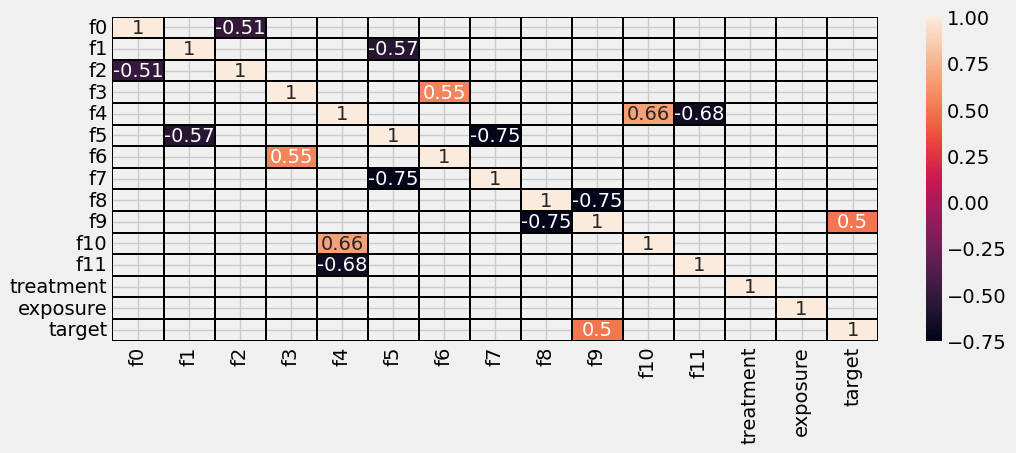

In [19]:
# проверим корреляцию признаков
corr = round(df.corr(), 2)

# выведем только данные с высоким уровнем корреляции
mask_1 = np.abs(corr) >= 0.50
mask_2 = np.abs(corr) <= -0.50
corr_data = corr[mask_1 | mask_2]

# визуализируем
fig = plt.figure(figsize = (11, 4))
sns.heatmap(corr_data, annot = True, linewidth=0.3, linecolor='black');

Объединим коррелирующие между собой признаки с помощью метода главных компонент.

In [7]:
pca = PCA(n_components = 1)
df['f0_f2'] = pca.fit_transform(df[['f0', 'f2']])

pca = PCA(n_components = 1)
df['f1_f5_f7'] = pca.fit_transform(df[['f1', 'f5', 'f7']])

pca = PCA(n_components = 1)
df['f3_f6'] = pca.fit_transform(df[['f3', 'f6']])

pca = PCA(n_components = 1)
df['f4_f10_f11'] = pca.fit_transform(df[['f4', 'f10', 'f11']])

pca = PCA(n_components = 1)
df['f8_f9'] = pca.fit_transform(df[['f8', 'f9']])

# старые признаки больше не понадобятся
df.drop(
    ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11'],
    axis = 1,
    inplace = True
)

Создаём вспомогательный признак target_class:
* 0 - **Control Non-Responders (CN)**

    Это клиенты, которым не была показана реклама (целевое воздействие), и от них не было интереса (y = 0, c)
* 1 - **Control Responders (CR)**

    Это клиенты, проявившие интерес без просмотра рекламы (целевого воздействия) (y = 1, c)
* 2 - **Treatment Non-Responders (TN)**

    Это клиенты, которым была показана реклама (совершено целевое воздействие), но они не откликнулись (y = 0, t)
* 3 - **Treatment Responders (TR)**

    Это клиенты, которым была показана реклама (совершено целевое воздействие) и они откликнулись (y = 1, t)

In [8]:
# признак понадобится нам при оценке качества uplift-модели
df['target_class'] = 0
df.loc[(df.treatment == 0) & (df.target == 1), 'target_class'] = 1
df.loc[(df.treatment == 1) & (df.target == 0), 'target_class'] = 2
df.loc[(df.treatment == 1) & (df.target == 1), 'target_class'] = 3

# посмотрим на распределение класса
df['target_class'].value_counts()

,count
target_class,
2,11305831
0,2016832
3,576824
1,80105


Датасет очень большой! В целях экономия времени и ввиду ограниченности ресурсов сократим размер датасета - оставим по 80 тыс. строк каждого из 'target_class'. Таким образом мы ещё и сбалансируем наш датасет.

In [9]:
df_0 = df[df['target_class'] == 0].sample(80000, random_state = 42)
df_1 = df[df['target_class'] == 1].sample(80000, random_state = 42)
df_2 = df[df['target_class'] == 2].sample(80000, random_state = 42)
df_3 = df[df['target_class'] == 3].sample(80000, random_state = 42)
df_short = pd.concat([df_0, df_1, df_2, df_3]).sample(
    frac = 1,
    random_state = 42
).reset_index(drop = True)

# определим колонки с факторами, тритментом и таргетом
feature_cols = ['exposure', 'f0_f2', 'f1_f5_f7', 'f3_f6', 'f4_f10_f11', 'f8_f9']
treatment_col = 'treatment'
target_col = 'target'

# разделим данные на тренировочную и тестовую выборки
df_train, df_test = train_test_split(
    df_short,
    stratify = df_short[[treatment_col, target_col]],
    random_state = 42,
    test_size = 0.3
)
print(df_train.shape)
print(df_test.shape)
df_train.head()

(224000, 9)
(96000, 9)


,treatment,exposure,target,f0_f2,f1_f5_f7,f3_f6,f4_f10_f11,f8_f9,target_class
291544,0,0,1,-6.994859,-0.281621,4.470728,-0.066155,15.117142,1
176182,0,0,0,-0.106065,-0.281621,0.651893,-0.066155,-2.837392,0
110834,1,0,0,6.092458,-0.281621,2.910558,-0.066155,-2.837762,2
10836,0,0,0,6.900238,-0.281621,2.910558,-0.066155,-2.837762,0
37044,0,0,0,-7.010721,-0.281621,4.470728,-0.066155,-2.837537,0


## Qini-curve и qini-score

Создадим функцию для построения qini-qurve и рассчёта qini-score. Она будет принимать на вход некоторый DataFrame, в котором должны содержаться признаки uplift_score (uplift-эффект) и target_class (класс пользователя).

In [10]:
# возьмём функцию для оценки qini-curve с прошлого занятия
def qini_df(df, title = 'train', figsize = (5, 3)):
    # отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values('uplift_score', ascending = False)
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)

    # посчитаем в отсортированном датафрейме основные
    # показатели, которые используются при расчёте qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1, 'n_c1'] = 1
    ranked.loc[ranked.target_class == 3, 'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t

    # посчитаем qini-curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'], 5)

    # добавим случайную кривую
    ranked['random_uplift'] = round(ranked['uplift_score'].rank(
        pct = True,
        ascending = False
    ) * ranked['uplift'].iloc[-1], 5)
    ranked['n'] = ranked['uplift_score'].rank(pct = True, ascending = False)

    # немного кода для визуализации
    fig = plt.figure(figsize = figsize)
    plt.plot(ranked['n'], ranked['uplift'], color = 'r', label = 'Model')
    plt.plot(
        ranked['n'],
        ranked['random_uplift'],
        color = 'b',
        label = 'RandomModel'
    )
    plt.legend()
    plt.title('Qini-curve for {} samples'.format(title))
    plt.show()
    qini_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    print('Qini-score: {:.3f}'.format(qini_score))

## Построение моделей и оценка качества

Построим аплифт-модели с помощью мета-алгоритмов и деревьев. Для мета-алгоритмов в качестве классификатора будем использовать линейные модели из библиотеки sklearn. Измерять качество аплифт-моделей будем "на глаз" по qini-curve и с помощью qini-score.

### S-learner

Проведем uplift-моделирование с помощью S-learner из библиотеки CausalML (BaseSClassifier). В качестве классификатора (learner) используем LogisticRegression с параметрами по умолчанию.

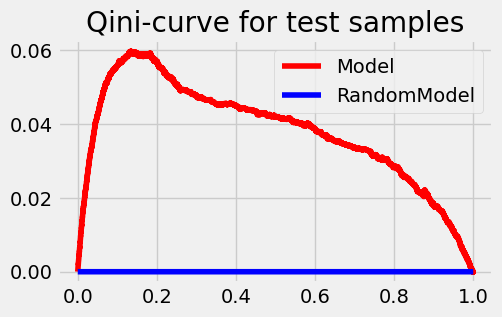

Qini-score: 3633.756


In [11]:
# создаём модель S-learner
s_learner = BaseSClassifier(learner = LogisticRegression())

# обучаем модель
s_learner.fit(
    X = df_train[feature_cols],          # датафрейм с факторами
    y = df_train[target_col],            # колонка с таргетом
    treatment = df_train[treatment_col]  # колонка с фактом воздействия
)

# делаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = s_learner.predict(df_test[feature_cols])
df_test['uplift_score'] = uplift_vals

# строим qini-qurve и выводим qini-score
qini_df(df_test, title = 'test')

### T-learner

Проведем uplift-моделирование с помощью T-learner из библиотеки CausalML (BaseTClassifier). В качестве классификатора (learner) используем LogisticRegression с параметрами по умолчанию.

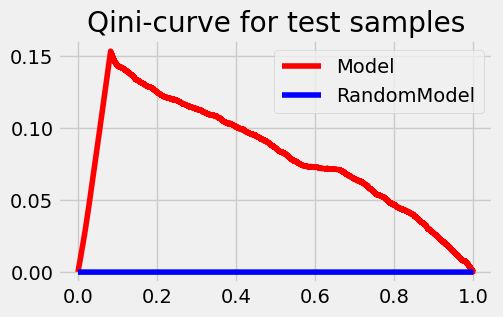

Qini-score: 7655.291


In [12]:
# создаём модель T-learner
t_learner = BaseTClassifier(learner = LogisticRegression())

# обучаем модель
t_learner.fit(
    X = df_train[feature_cols],          # датафрейм с факторами
    y = df_train[target_col],            # колонка с таргетом
    treatment = df_train[treatment_col]  # колонка с фактом воздействия
)

# делаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = t_learner.predict(df_test[feature_cols])
df_test['uplift_score'] = uplift_vals

# строим qini-qurve и выводим qini-score
qini_df(df_test, title = 'test')

### X-learner

Проведем uplift-моделирование с помощью X-learner из библиотеки CausalML (BaseXClassifier).
* В качестве outcome_learner используем LogisticRegression с параметрами по умолчанию.
* В качестве effect_learner возьмём LinearRegression с параметрами по умолчанию.

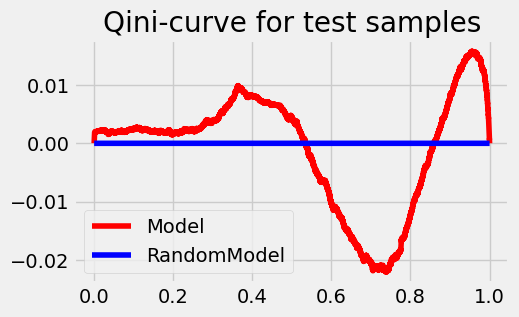

Qini-score: -66.836


In [13]:
# создаём модель X-learner
x_learner = BaseXClassifier(
    outcome_learner = LogisticRegression(),
    effect_learner = LinearRegression()
)

# обучаем модель
x_learner.fit(
    X = df_train[feature_cols],          # датафрейм с факторами
    y = df_train[target_col],            # колонка с таргетом
    treatment = df_train[treatment_col]  # колонка с фактом воздействия
)

# делаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = x_learner.predict(df_test[feature_cols])
df_test['uplift_score'] = uplift_vals

# строим qini-qurve и выводим qini-score
qini_df(df_test, title = 'test')

### R-learner

Проведем uplift-моделирование с помощью R-learner из библиотеки CausalML (BaseRClassifier).
* В качестве outcome_learner используем LogisticRegression с параметрами по умолчанию.
* В качестве effect_learner возьмём LinearRegression с параметрами по умолчанию.

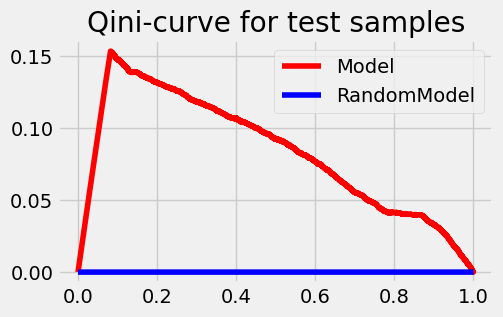

Qini-score: 7905.087


In [14]:
# создаём модель R-learner
r_learner = BaseRClassifier(
    outcome_learner = LogisticRegression(),
    effect_learner = LinearRegression(),
    random_state = 42
)

# обучаем модель
r_learner.fit(
    X = df_train[feature_cols],          # датафрейм с факторами
    y = df_train[target_col],            # колонка с таргетом
    treatment = df_train[treatment_col]  # колонка с фактом воздействия
)

# делаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = r_learner.predict(df_test[feature_cols])
df_test['uplift_score'] = uplift_vals

# строим qini-qurve и выводим qini-score
qini_df(df_test, title = 'test')

### Uplift Tree

Проведём uplift-моделирование  с помощью Uplift-дерева из библиотеки CausalML (UpliftTreeClassifier). Функция predict у деревьев возвращает uplift-эффекты для каждой группы воздействия. Нас интересует только наличие воздействия (столбец под индексом 1).

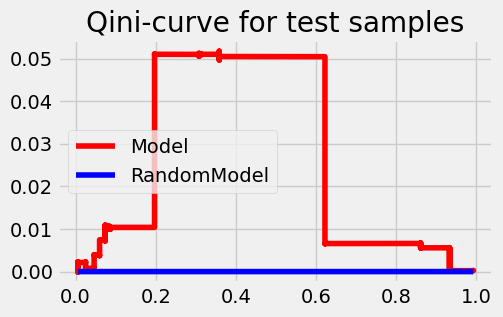

Qini-score: 2441.646


In [20]:
# создаём простое дерево
uplift_tree = UpliftTreeClassifier(
    max_depth = 5,
    min_samples_leaf = 200,
    min_samples_treatment = 50,
    n_reg = 100,
    evaluationFunction = 'ED',
    control_name = '0',
    random_state = 42
)

# обучаем модель
uplift_tree.fit(
    X = df_train[feature_cols],  # датафрейм с факторами
    y = df_train[target_col],    # колонка с таргетом
    # фактор воздействия необходимо преобразовать в строку
    treatment = df_train[treatment_col].apply(str)
)

# делаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = uplift_tree.predict(df_test[feature_cols])[:, 1]
df_test['uplift_score'] = uplift_vals

# строим qini-qurve и выводим qini-score
qini_df(df_test, title = 'test')

Можем посмотреть на вид построенного дерева.

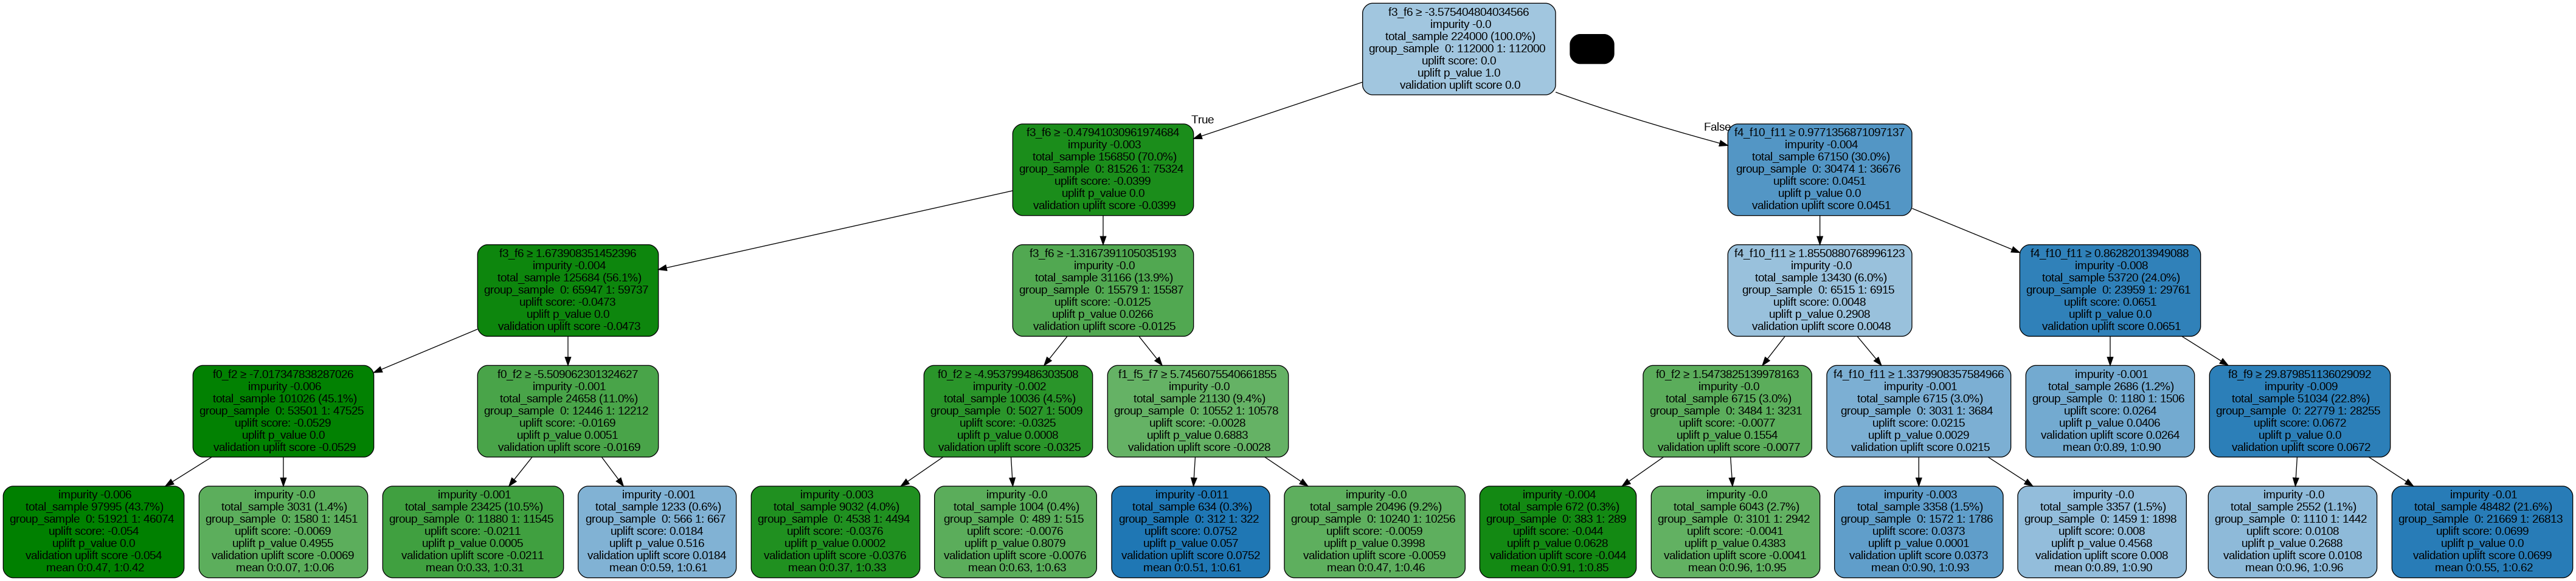

In [26]:
# вызываем функцию для визуализации
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, feature_cols)
Image(graph.create_png())

### Uplift Random Forest

Проведём uplift-моделирование с помощью UpliftRandomForest из библиотеки CausalML (UpliftRandomForestClassifier).

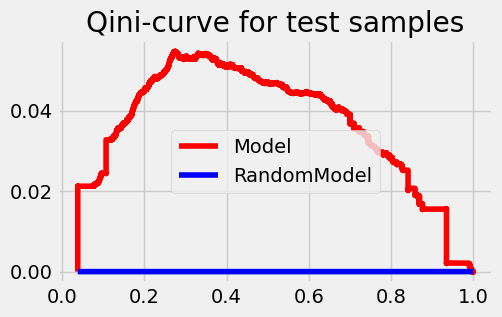

Qini-score: 3375.017


In [17]:
# создаём случайный лес
uplift_forest = UpliftRandomForestClassifier(
    n_estimators = 100,
    max_depth = 5,
    min_samples_leaf = 200,
    min_samples_treatment = 50,
    n_reg = 100,
    evaluationFunction = 'ED',
    control_name = '0',
    random_state = 42
)

# обучаем модель
uplift_forest.fit(
    X = df_train[feature_cols].values,  # датафрейм с факторами
    y = df_train[target_col].values,    # колонка с таргетом
    # фактор воздействия необходимо преобразовать в строку
    treatment = df_train[treatment_col].apply(str).values
)

# делаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = uplift_forest.predict(df_test[feature_cols])
df_test['uplift_score'] = uplift_vals

# строим qini-qurve и выводим qini-score
qini_df(df_test, title = 'test')

## Выводы

На основании полученных результатов, можно сделать вывод, что в этом бизнес-кейсе лучше использовать аплифт-модели построенные с помощью мета-алгоритмов, нежели деревьев. Полагаю, что это может быть связано с тем, что в наших данных используются в основном непрерывные признаки, на которых хорошо уловилась взаимосвязь с целевым признаком с помощью линейных моделей.

T- и R- learner`ы при заданных моделях и их параметрах показали очень схожие qini-curve и получили найвысшие qini-score:
* T-learner qini-score: 7655.291
* R-learner qini-score: 7905.087

Мы использовали только базовые модели. Можно поуправлять параметрами представленных моделей, взять более тяжёлые модели или расширить обучающую выборку, чтобы повысить результаты. Но, усложнение используемых моделей приведёт к значительному увеличению времени обучения.